In [32]:
import numpy as np
import matplotlib.pyplot as plt
import edmcmc as edm
import corner
import time
import pandas as pd
import radvel
import math

#globally change font size for plots
plt.rcParams['font.size'] =17
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

In [33]:
def sort_by_phase(time, period, rvs):
    data = {'phase': time%period,
            'rvs': rvs}
    df_ti = pd.DataFrame(data=data)
    df_ti_sorted = df_ti.sort_values(by=['phase'])
    
    return df_ti_sorted['phase'], df_ti_sorted['rvs']

In [35]:
# load harps data and corrected timeseries

cnn_results = pd.read_csv("Results_colab/inject_recov_0.4ms365d_10d_allevals_preds_CNN_02_22_2022.csv")
#"Results_colab/inject_recov_0.4ms365d_10d_allevals_preds_CNN_02_22_2022.csv")
cnn_results

,labels,preds,BJD
0,2.124018,2.133789,0.000000
1,3.526592,3.357373,9.996276
2,3.709279,4.619067,11.000992
3,3.884198,4.522746,12.004133
4,5.335265,5.595530,13.004789
...,...,...,...
523,-2.300436,-3.109858,1085.036255
524,-1.742203,-2.320747,1088.031372
525,-1.182160,-1.600293,1089.966553
526,-1.293910,-0.771427,1090.993042


In [36]:
uncertainty_true = 0.451640314 # From H-N avg error


# format data for mcmc fit
rv_np = np.array(list(cnn_results["labels"]-cnn_results["preds"]))
s_rv_np = np.ones_like(cnn_results["labels"]) * uncertainty_true
time_np = np.array(cnn_results["BJD"])-np.min(cnn_results["BJD"])

## 1 Planet Model

In [37]:
eval_method = '1 Planet Model'

#K*np.sin(2*np.pi/p*bjd-phase)

In [38]:
def loglikelihood(theta, t, y, yerr):
    amplitude, jitterpar, D, period, tp= theta # e, om  = theta
    model = amplitude*np.sin(2*np.pi/period*t-tp)+D#amplitude *radvel.kepler.rv_drive(t, [period, tp,e, om, 1.0], use_c_kepler_solver=True) + D
    sigma2 = yerr**2 + jitterpar**2
    chisq = np.sum((y - model)**2 / sigma2) 
    
    #loglikelihood =  -0.5 *np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))#* chisq / sigma2 + np.log(sigma2))
    
    newsig = np.sqrt(sigma2)
    
    negloglikelihood = np.sum(0.5 * (y - model)**2 / (newsig)**2 + np.log(newsig))
    #print(loglikelihood)
    return -1*negloglikelihood

In [39]:
def chisq(theta, t, y, yerr):
    amplitude, jitterpar, D, period, tp  = theta#, e, om 
    model = amplitude*np.sin(2*np.pi/period*t-tp)+D #amplitude *radvel.kepler.rv_drive(t, [period, tp,e, om, 1.0], use_c_kepler_solver=True) + D 
    sigma2 =jitterpar**2 + yerr**2 
    chisq = np.sum((y - model)**2 / sigma2) 
    return chisq

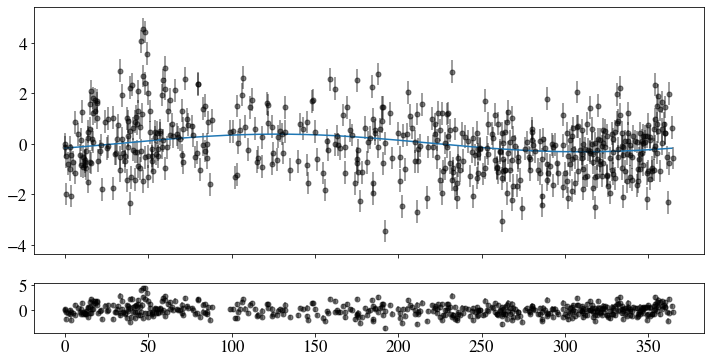

In [40]:
time_ti = np.linspace(np.min(time_np), np.max(time_np), 1000)

amplitude = 0.35
period = 365
tp =  120#288.1+0.2 #289.9##-0.2#289.7#-2# -1.8#-0.1# 288.1-0.2#
#e = 0.0 #0.52
#om = 0#192/180*np.pi#3.0
D = 0.04#30 +200 #-1.8102179
jitterpar = 1#28.6852

def one_planet_model(time, theta):
    amplitude, period, tp,e, om, D = theta
    return amplitude *radvel.kepler.rv_drive(time, [period, tp,e, om, 1.0], use_c_kepler_solver=True) + D 

def one_circ_planet_model(time, theta):
    amplitude, period, tp, D = theta
    return amplitude*np.sin(2*np.pi/period*time-tp)+D


data = {'time': time_ti%period,
       'rvs': one_circ_planet_model(time_ti, np.array([amplitude, period, tp, D]))}
df_ti = pd.DataFrame(data=data)
df_ti_sorted = df_ti.sort_values(by=['time'])

y_preds_time_np = one_circ_planet_model(time_np, np.array([amplitude, period, tp, D]))

fig, axes = plt.subplots(2,1, figsize=(12, 6),  sharex=True,  gridspec_kw={'height_ratios': [3, 0.6]})

ax = axes[0]
ax.errorbar(time_np%period, rv_np,yerr=s_rv_np, fmt = 'o', color='k', alpha=0.5)
ax.plot(df_ti_sorted['time'], df_ti_sorted['rvs'])

ax = axes[1]
ax.errorbar(time_np%period, rv_np-y_preds_time_np,yerr=s_rv_np, fmt = 'o', color='k',  alpha=0.5)


solnx = np.array([amplitude+0.4, jitterpar , D, period, tp])#, e, om])

In [41]:
def log_prior(theta):
    amplitude, jitterpar, D, period, tp = theta #, e, om = theta
    #amplitude, jitterpar, D, a0, a1, a2, a3, a4, a5, a6, a7, a8, a9, a10 = theta
    if 0 < amplitude < 3 and 0<period<450 and -200<D<200  and 0<jitterpar<80 and 115<tp<125: #and 0<om<6.28 and 0.2<e<0.7
        return 0.0
    return -np.inf

In [42]:
def log_probability(theta, t, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + loglikelihood(theta, t, y, yerr)

In [43]:
loglikelihood(solnx, time_np,rv_np,s_rv_np)

-342.8257885944938

In [44]:
width = np.array([0.1, 0.15, 0.1, 0.5, 0.4])# [0.4, 0.15, 0.1, 15, 0.4]#[2e2, 2, 0.1, 0.05, 3, 0.25, 0.21]

out = edm.edmcmc(log_probability, solnx, width,
             args=(time_np,rv_np,s_rv_np), nwalkers=200, nlink = 18000, nburnin=15000)
print(np.median(out.flatchains[:,0]), '+/-', np.std(out.flatchains[:,0]), ';    ', np.median(out.flatchains[:,1]), '+/-', np.std(out.flatchains[:,1]))


0 days, 00:00:00.0 remains. Link 18000 of 18000. Acceptance Rate= 0.28
0.5307829287069096 +/- 0.07470397235381955 ;     1.0246144228984218 +/- 0.037817673293319955


In [45]:
np.shape(out.flatchains)

(600000, 5)

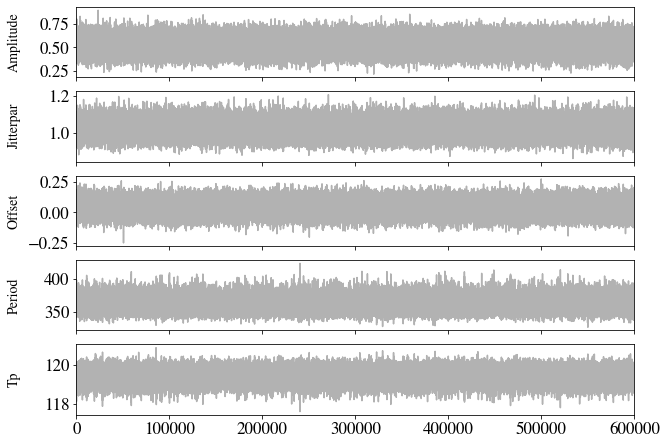

In [46]:
fig, axes = plt.subplots(len(solnx), figsize=(10, 1.5*len(solnx)), sharex=True)
samples = out.flatchains#[505000:,]
labels = ["Amplitude", "Jitterpar","Offset", "Period", "Tp"]
for i in range(len(labels)):
    ax = axes[i]
    ax.plot(samples[:, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i], size=14)
    ax.yaxis.set_label_coords(-0.1, 0.5)

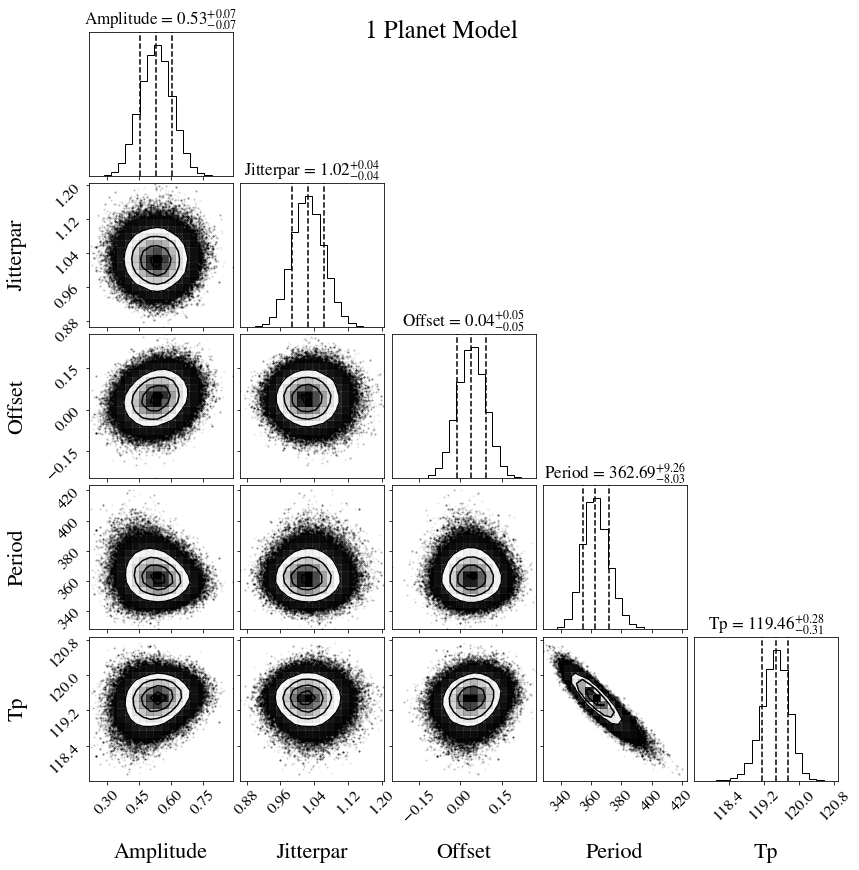

In [47]:
# global variable - set font-size to 14
plt.rcParams['font.size'] =16

# plot corner plot
fig = corner.corner(
    out.flatchains,#[505000:,],
    labels=labels,
    quantiles=[0.159, 0.5, 0.841],
    show_titles=True,
    #title_fmt=".2E",
    title_kwargs=dict(fontsize=17),
    label_kwargs=dict(fontsize=22),
    labelpad = 0.13)

fig.suptitle(eval_method, fontsize=25)

# revert global font-size to 17
plt.rcParams['font.size'] =17

In [380]:
flat_samples = out.get_chains(nthin =5, nburnin = 6000, flat=True)

#thinflatchains[:,0]

In [381]:
from IPython.display import display, Math

for i in range(len(labels)):
        mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
        q = np.diff(mcmc)
        txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
        txt = txt.format(mcmc[1], q[0], q[1], labels[i])
        display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [382]:
amp_mcmc = np.percentile(flat_samples[:, 0], [50])[0]
jitterpar_mcmc = np.percentile(flat_samples[:, 1], [50])[0]
D_mcmc = np.percentile(flat_samples[:, 2], [50])[0]
period_mcmc = np.percentile(flat_samples[:, 3], [50])[0]
tp_mcmc = np.percentile(flat_samples[:, 4], [50])[0]

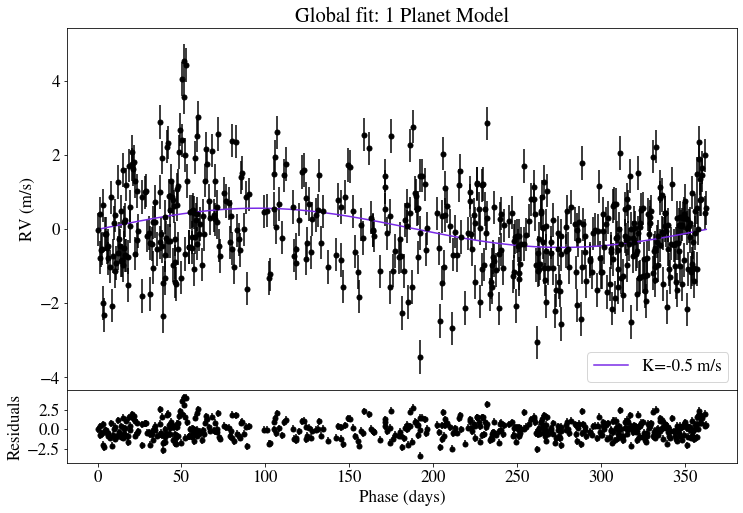

In [383]:
ti_np = np.arange(np.min(time_np), np.max(time_np), 0.1)%period_mcmc
y_preds = one_circ_planet_model(ti_np, np.array([amp_mcmc, period_mcmc, tp_mcmc, D_mcmc]))
y_preds_time_np = one_circ_planet_model(time_np, np.array([amp_mcmc, period_mcmc, tp_mcmc, D_mcmc]))


data_ti = {'ti_np': ti_np,
        'y_preds': y_preds}
df_di = pd.DataFrame(data=data_ti)
df_di_sorted = df_di.sort_values(by=['ti_np'])


fig, ax = plt.subplots(2,1, figsize=(12, 8),sharex=True,  gridspec_kw={'height_ratios': [3, 0.6]})
fig.subplots_adjust(hspace=0.0, wspace=0.0)
ax[0].plot(df_di_sorted["ti_np"], df_di_sorted["y_preds"], color='#7829e6',
        label="K="+str(round(amp_mcmc,1))+" m/s")
ax[0].errorbar(time_np%period_mcmc, rv_np,yerr=s_rv_np, fmt = 'o', color='k')
ax[0].set_ylabel("RV (m/s)")


ax[0].set_title("Global fit: "+eval_method)
#plt.title("First 1/3 of the data fit")
#plt.title("Second 1/3 of the data fit")
#plt.title("Third 1/3 of data fit")


ax[1].errorbar(time_np%period_mcmc, rv_np-y_preds_time_np,yerr=s_rv_np, fmt = 'o', color='k')
ax[1].set_ylabel("Residuals")
ax[1].set_xlabel("Phase (days)")

ax[0].legend(loc="lower right")

best period: 362.78 d
best offset: 0.04043322858509828


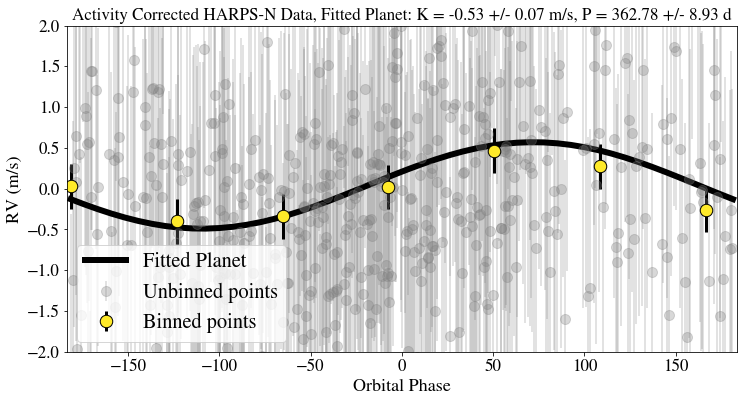

In [384]:
from astropy.table import Table
from astropy.time import Time
import astropy.units as u
from astropy.timeseries import TimeSeries

std_amp_mcmc = np.round(np.std(flat_samples[:, 0]), 2)
amp_mcmc = np.round(np.percentile(flat_samples[:, 0], [50])[0],2)
std_period_mcmc = np.round(np.std(flat_samples[:, 3]), 2)
period_mcmc = np.round(np.percentile(flat_samples[:, 3], [50])[0],2)
std_tp_mcmc = np.round(np.std(flat_samples[:, 4]), 2)
tp_mcmc = np.round(np.percentile(flat_samples[:, 4], [50])[0],2)

#create a table that can be read to create a Timeseries object
t = Table([time_np,rv_np], names=('x', 'y'))
time = Time(t["x"], format='mjd')

# convert mjd to right isot
t = Table([time.isot, rv_np], names=('time', 'y'))
ts1 = TimeSeries(t)
                     
#create a table that can be read to create a Timeseries object
t2 = Table([time_np,one_circ_planet_model(time_np, np.array([amp_mcmc, period_mcmc, tp_mcmc, D_mcmc]))], names=('x', 'y'))
time2 = Time(t2["x"], format='mjd')

# convert mjd to right isot
t2 = Table([time.isot, one_circ_planet_model(time_np, np.array([amp_mcmc, period_mcmc, tp_mcmc, D_mcmc]))], names=('time', 'y'))
ts2 = TimeSeries(t2)

# Plot phase-folded
#period = 1/best_frequency* u.day
period = period_mcmc* u.day
print("best period: "+str(period))
print("best offset: "+str(D_mcmc))
ts_folded = ts1.fold(period=period)
ts2_folded = ts2.fold(period=period)

from astropy.timeseries import aggregate_downsample
harps_binned = aggregate_downsample(ts_folded, time_bin_size=58* u.day, aggregate_func=np.nanmedian)

sd_labels_harps = np.std(cnn_results["labels"])
sd_corr_harps = np.std(rv_np)

err = [sd_labels_harps]*len(ts_folded.time.jd)
err_binned = [sd_labels_harps/(np.sqrt(50))]*len(harps_binned['y'])

fig, ax = plt.subplots(1,1,figsize=(12, 6))
#plt.errorbar(ts_folded.time.jd, ts_folded['y'], yerr = err, fmt = 'o')
ax.errorbar(ts_folded.time.jd, ts_folded['y'], yerr = err, ecolor= 'grey', 
            color='grey',linestyle='none',marker='.', markersize=20, alpha=0.3, label="Unbinned points")
#ax.plot(ts2_folded.time.jd, ts2_folded['y'], 'k.', markersize=10, label="planet")

x_range = np.linspace(-period_mcmc/2,period_mcmc/2)
ax.plot(x_range, one_circ_planet_model(x_range, np.array([amp_mcmc, period_mcmc, tp_mcmc-0.4, D_mcmc])),
        'k',linewidth=6, 
        label="Fitted Planet")#, T_p: "+str(tp_mcmc)+" +/- "+str(std_tp_mcmc))
#ax.plot(x_range, amplitude_true*np.sin(B_true*x_range+C_true), 'b',linewidth=6, label="Injected Planet Signal")
ax.errorbar(harps_binned.time_bin_start.jd, harps_binned['y'],yerr = err_binned, elinewidth=3,ecolor='k',
            color='#FFEA29',linestyle='none',marker='.', markersize=25, markeredgewidth=1, 
            markeredgecolor='k', label="Binned points")
ax.set_ylim(-2,2)
ax.set_xlim(-period_mcmc/2-2,period_mcmc/2+2)
ax.set_xlabel('Orbital Phase', size=18)
ax.set_ylabel('RV (m/s)', size=18)

ax.set_title('Activity Corrected HARPS-N Data, Fitted Planet: K = '+str(amp_mcmc)+" +/- "+str(std_amp_mcmc)+" m/s, P = "+
            str(period_mcmc)+" +/- "+str(std_period_mcmc)+" d", size=17)
             #str(period_mcmc)+" +/- "+str(period_std_mcmc)+" d", size=15) #, m = 0.5Me
ax.legend(loc='lower left', fontsize='large')


0.4
0.0
4.530210453423379
0.0


<IPython.core.display.Math object>

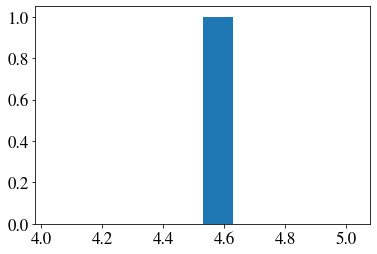

In [19]:
amplitudes =np.array([0.4])#flat_samples[:, 0] #np.sqrt(sin_prop**2 + cos_prop**2)

print(np.median(amplitudes))
print(np.std(amplitudes))

Mstar = 1.02 *1.989*10**30 #1.1 or 1.2 solar masses
Mstar_uncertainty = 0.12 *1.989*10**30
eccentricity =0.0
K = amplitudes

mps1 = (Mstar**2 * period * 24.0 * 3600.0 * (K)**3 * (1 - eccentricity**2)**(3.0/2.0) / (2.0 * np.pi * 6.67e-11))**(1.0/3.0) / (5.974e24)

plt.hist(mps1)

print(np.median(mps1))
print(np.std(mps1))


mass = np.median(mps1)
mass_sd = np.std(mps1)

from IPython.display import display, Math
for i in range(0,1):
    mcmc = np.percentile(mps1, [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], "Mass")
    display(Math(txt))

In [18]:
! pip install Math

ERROR: Could not find a version that satisfies the requirement Math
ERROR: No matching distribution found for Math
